In [1]:
import joblib
import os
import math
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome.connectivity_matrices import sym_matrix_to_vec
from neuroginius.plotting import plot_matrix
from neuroginius.atlas import Atlas

from cogpred.utils.configuration import get_config
from cogpred.transformers import MatrixMasker
from cogpred.loading import make_training_data
from cogpred.utils.naming import make_run_path

config = get_config()
conn_dir = config["connectivity_matrices"]

ATLAS = "schaefer200"

atlas = Atlas.from_name(ATLAS, soft=False)

k = 3
REFNET = np.unique(atlas.macro_labels)
INTER = REFNET
#REFNET = ("Default",)
#INTER = ("Default",)

sns.reset_defaults()

In [2]:
matrices, metadata = make_training_data(conn_dir, ATLAS, k, test_centre=None)
run_path = make_run_path(
    config["output_dir"],
    k=k,
    feat="fc",
    atlas=ATLAS,
    net="".join(REFNET),
    inter="".join(INTER)
)

if len(run_path.name) > 55:
    print("too long")
    run_path = make_run_path(
        config["output_dir"],
        k=k,
        feat="fc",
        atlas=ATLAS,
        net="all",
    )
    
os.makedirs(run_path, exist_ok=True)
metadata.to_csv(run_path / "metadata.csv")

Dropping 12 subjects because of lacking MMMSE
too long


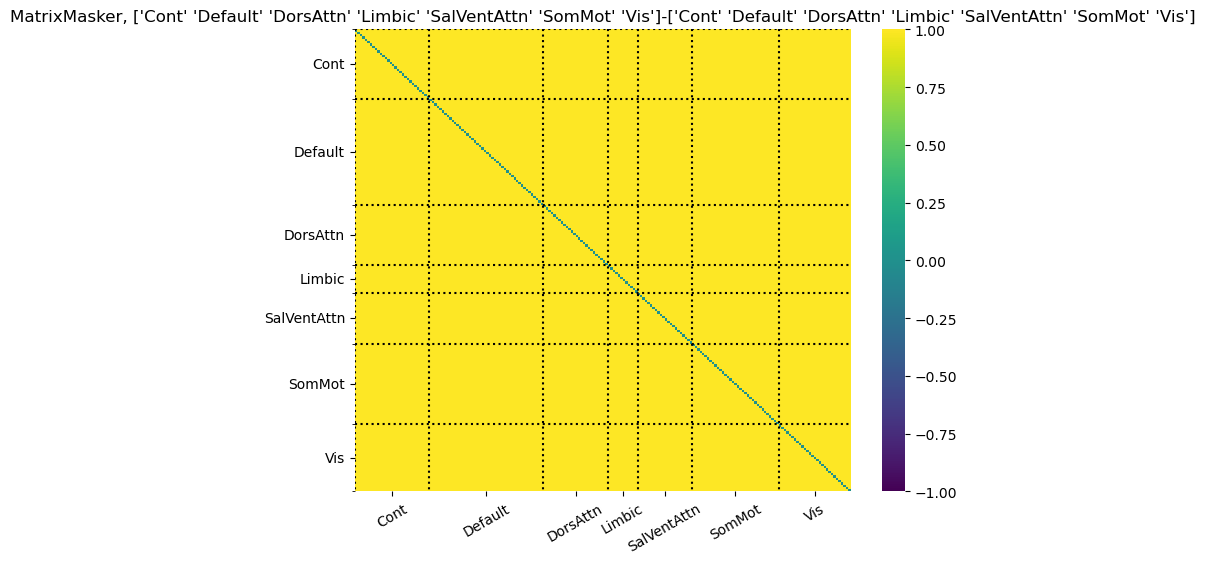

In [3]:
masker = MatrixMasker(REFNET, INTER, atlas=atlas).fit(matrices, metadata)

masker.fit(matrices).plot(cmap="viridis")
plt.show()

In [4]:
from sklearn.metrics import f1_score
def score_func(y_test, y_pred):
    f1_scores = []
    for curr_label in np.unique(y_test):
        y_test_ovr = np.where(y_test == curr_label, 1, 0)
        y_pred_ovr = np.where(y_pred == curr_label, 1, 0)
        f1_scores.append(
            f1_score(y_test_ovr, y_pred_ovr)
        ) 
    return f1_scores # No point in yielding

In [5]:
from cogpred.supervised import run_cv
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold
from nilearn.connectome import vec_to_sym_matrix
from cogpred.matrices import compute_mat_size

net = SGDClassifier(
        loss="log_loss",
        penalty="l1",
        max_iter=3000,
        random_state=2024,
    )

clf = Pipeline(
    [
    ("matrixmasker", MatrixMasker(REFNET, INTER, atlas=atlas)),
    ("scaler", preprocessing.StandardScaler()),
    ("classifier", net)
    ],
    verbose=False
)


cats = ("stable", "slow", "steep")
outer_cv = GroupKFold(n_splits=8)

test_scores, cm, patterns = run_cv(clf, matrices, metadata, outer_cv)

masker = clf.named_steps["matrixmasker"]
l = len(masker.vec_idx_)
n_regions = compute_mat_size(l)
hmat = vec_to_sym_matrix(
    patterns.transpose((0, 2, 1)), diagonal=np.zeros((outer_cv.n_splits, k, n_regions))
)

              precision    recall  f1-score   support

           0       0.93      0.57      0.71       221
           1       0.06      0.36      0.11        14
           2       0.00      0.00      0.00         3

    accuracy                           0.55       238
   macro avg       0.33      0.31      0.27       238
weighted avg       0.86      0.55      0.66       238

              precision    recall  f1-score   support

           0       0.87      0.46      0.60       101
           1       0.18      0.57      0.28        23
           2       0.12      0.12      0.12        16

    accuracy                           0.44       140
   macro avg       0.39      0.38      0.33       140
weighted avg       0.67      0.44      0.49       140

              precision    recall  f1-score   support

           0       0.88      0.57      0.69       103
           1       0.30      0.56      0.39        25
           2       0.19      0.45      0.27        11

    accuracy        

/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

              precision    recall  f1-score   support

           0       0.85      0.40      0.55       109
           1       0.26      0.48      0.34        31
           2       0.00      0.00      0.00         0

    accuracy                           0.42       140
   macro avg       0.37      0.30      0.29       140
weighted avg       0.72      0.42      0.50       140

              precision    recall  f1-score   support

           0       0.73      0.54      0.62        87
           1       0.35      0.58      0.44        38
           2       0.21      0.20      0.21        15

    accuracy                           0.51       140
   macro avg       0.43      0.44      0.42       140
weighted avg       0.58      0.51      0.53       140

              precision    recall  f1-score   support

           0       0.74      0.24      0.36       110
           1       0.15      0.50      0.23        26
           2       0.10      0.33      0.15         6

    accuracy        

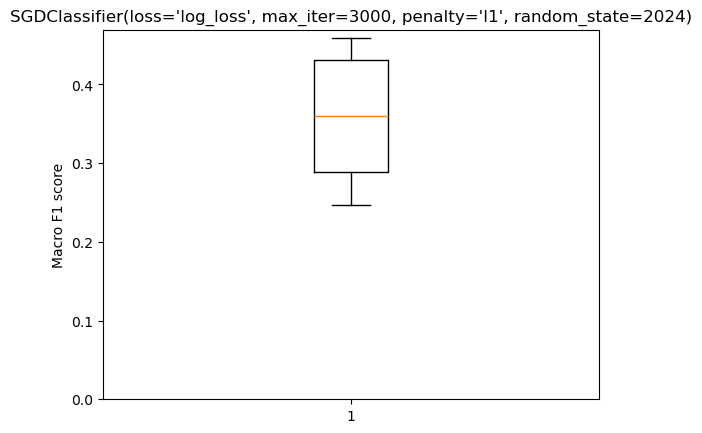

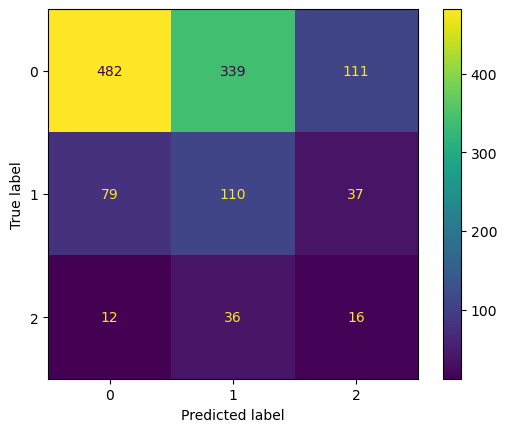

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.boxplot(test_scores)
plt.ylim(0)
plt.title(clf.named_steps["classifier"])
plt.ylabel("Macro F1 score")
plt.show()

disp = ConfusionMatrixDisplay(cm.astype(int))
disp.plot()
plt.show()

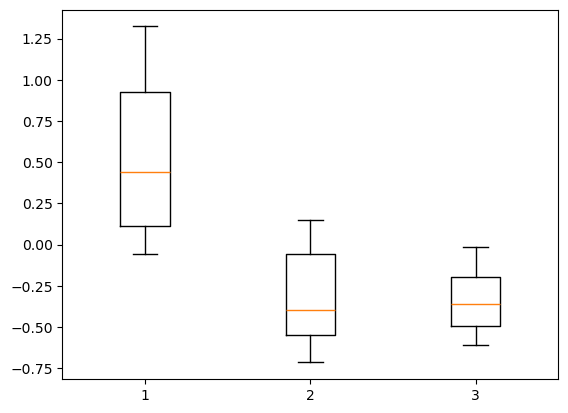

In [7]:
r_stable = hmat[:, 0, ...].mean(axis=(1, 2))
r_slow = hmat[:, 1, ...].mean(axis=(1, 2))
r_steep = hmat[:, 2, ...].mean(axis=(1, 2))
plt.boxplot(
    (
        r_stable,
        r_slow,
        r_steep,
    )
)
plt.show()

In [105]:
atlas = Atlas.from_name(ATLAS)
def net_select(label):
    if label in masker.refnet or label in masker.interaction:
        return 1
    return 0

regions = []
for region, network in zip(atlas.labels, atlas.macro_labels):
    if network in masker.refnet or network in masker.interaction:
        regions.append(region)

# Hack to remove that annoying dtype thing from nilearn
regions = list(np.array(regions).astype(str))

class MockAtlas:
    def __init__(self) -> None:
        self.macro_labels = list(map(self.region_split, regions))

    @staticmethod
    def region_split(label):
        return label.split("_")[-2]
        
if np.all(REFNET == np.unique(atlas.macro_labels)):
    disp_atlas = atlas
else:
    disp_atlas = MockAtlas()


/tmp/ipykernel_293054/1449391843.py:15: RuntimeWarning: invalid value encountered in divide
  cvmap = np.std(hmat[:, i, ...], axis=0) / meanmap
/tmp/ipykernel_293054/1449391843.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


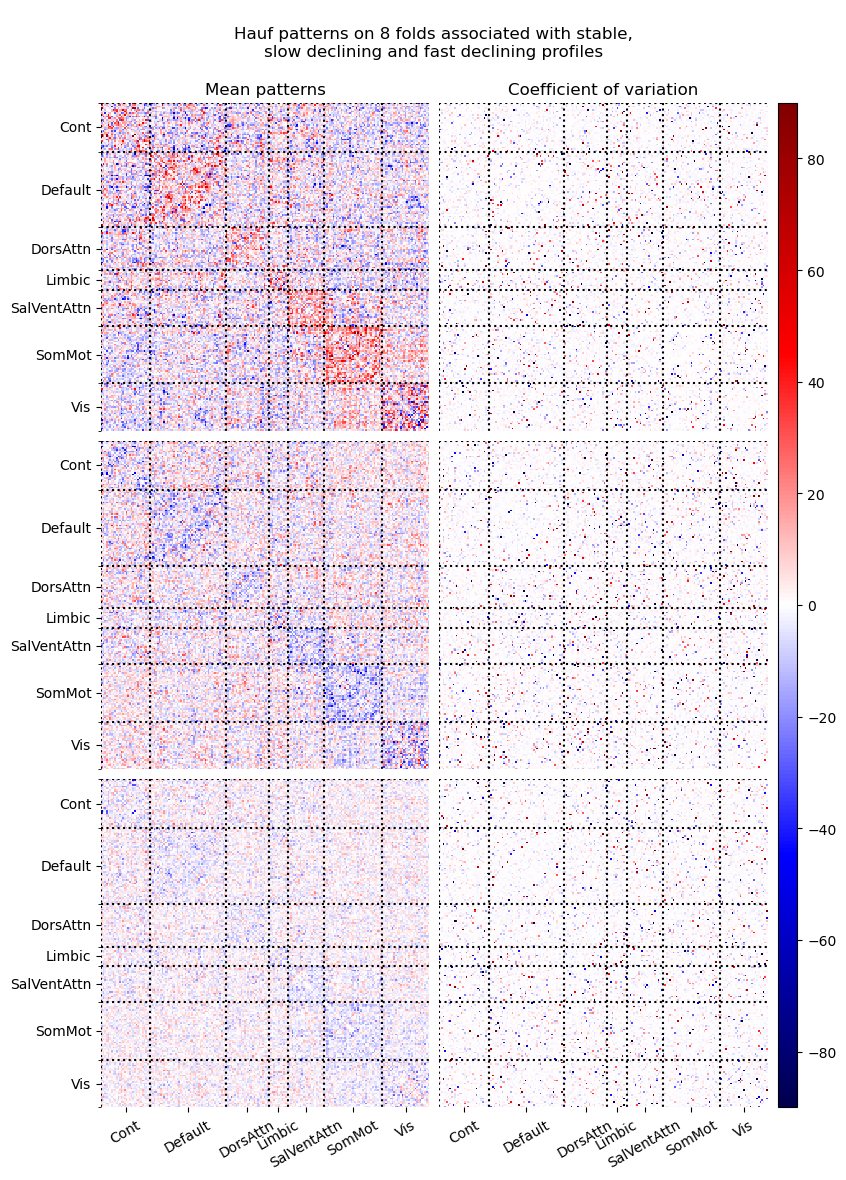

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.cm import ScalarMappable
import matplotlib as mpl

vmin = -90
vmax = 90
bounds=(vmin, vmax)
cmap = "seismic"
vals = []

for i, cat in enumerate(cats):
    meanmap = np.mean(hmat[:, i, ...], axis=0)
    cvmap = np.std(hmat[:, i, ...], axis=0) / meanmap
    vals.append(meanmap)
    vals.append(cvmap)

fig = plt.figure(figsize=(9, 12))

grid = AxesGrid(fig, 111,
                nrows_ncols=(3, 2),
                axes_pad=0.1,
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                cbar_size="2%",
                cbar_pad=0.1
                )

for i, (val, ax) in enumerate(zip(vals,grid)):
    ax = plot_matrix(
        val,
        disp_atlas,
        axes=ax,
        bounds=bounds,
        cmap="seismic",
        cbar=False
    )
    # Keep ticks only where we have labels
    if i <= 3:
        ax.xaxis.set_ticks_position('none') 
    if i % 2 != 0:
        ax.yaxis.set_ticks_position('none') 

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)
grid.cbar_axes[0].colorbar(ScalarMappable(norm=norm, cmap=cmap))

for cax in grid.cbar_axes:
    cax.set_label(None)

grid.axes_row[0][1].set_title("Coefficient of variation")
grid.axes_row[0][0].set_title("Mean patterns")
fig.suptitle(
    f"""
    Hauf patterns on {len(hmat)} folds associated with stable,
    slow declining and fast declining profiles
    """)
fig.tight_layout()


plt.show()

# Test significant score

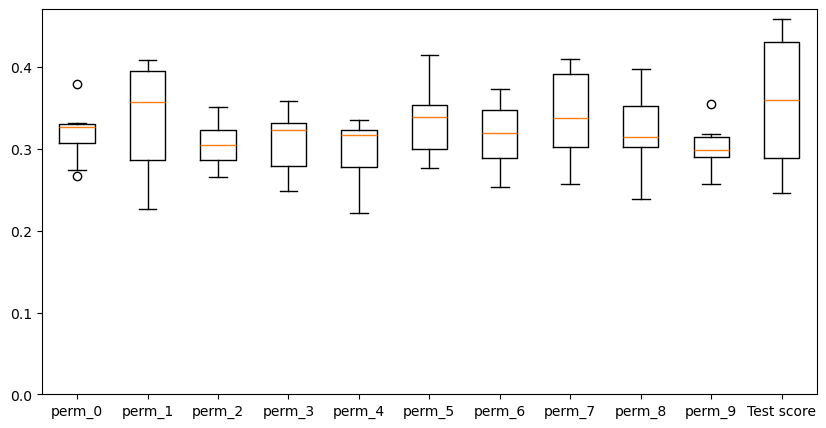

In [66]:
import random

N = 5000
#p = Path("/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-fc_atlas-schaefer200_net-Default_inter-Default")
p = run_path
perm_res = joblib.load(p / f"{N}_permutations_res.joblib")
permscores = [pr[0] for pr in perm_res]
permweights = [pr[1] for pr in perm_res]

disp_sample = random.sample(permscores, k=10)
disp_sample.append(test_scores)

labels = [f"perm_{i}" for i in range(10)]
labels.append("Test score")

plt.subplots(figsize=(10, 5))
plt.boxplot(disp_sample, labels=labels)
plt.ylim(0)
plt.show()

median_scores = tuple(map(np.median, permscores))
median_test = np.median(test_scores)
pvalue = (np.sum(median_test < median_scores)) / N # TODO Should we really add one?

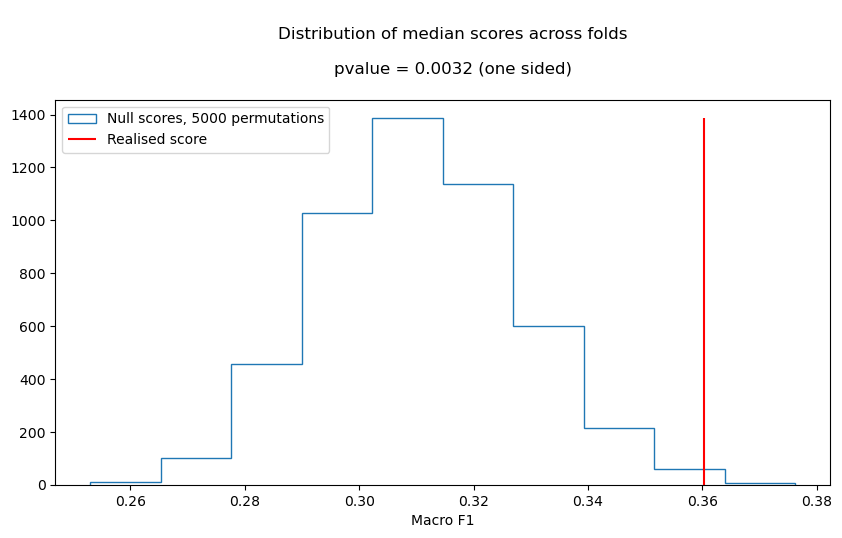

In [23]:
f, ax = plt.subplots(figsize=(10, 5))
h = ax.hist(median_scores, histtype="step", label=f"Null scores, {N} permutations")
ax.vlines(median_test, ymin=0, ymax=np.max(h[0]), color="red", label="Realised score")
ax.set_title(
    f"""
    Distribution of median scores across folds\n
    pvalue = {pvalue} (one sided)
    """
)
ax.legend(loc="upper left")
ax.set_xlabel("Macro F1")
plt.show()

# Multiple comparisons adjustement

## Single step max T

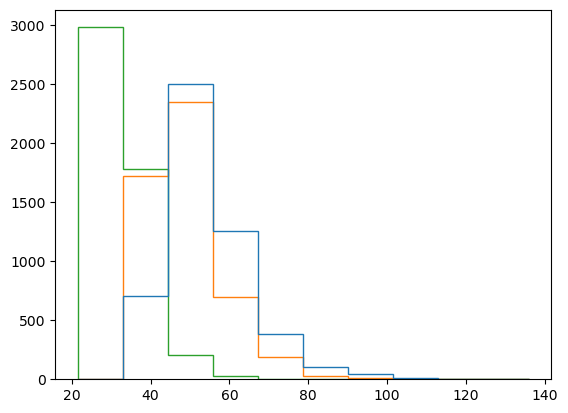

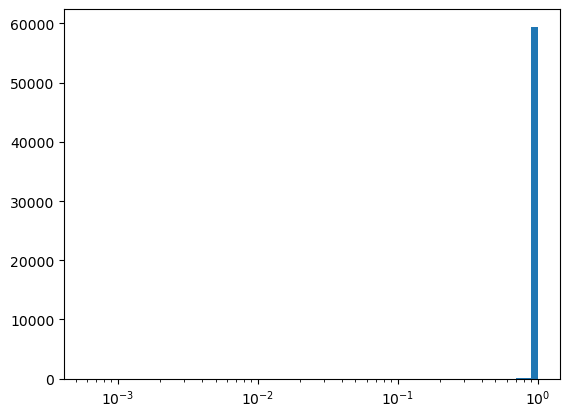

In [24]:
# Single step procedure
mean_patterns = np.mean(patterns, axis=0)

max_distribution = np.zeros((N, k))
for b, pm in enumerate(permweights):
    t_perm = np.mean(pm, axis=0) # Compute t stats for each hypothesis
    perm_max = np.max(np.abs(t_perm), axis=0)
    max_distribution[b] = perm_max

ss_pvalues = np.full_like(mean_patterns, False)
for j, region_pattern in enumerate(mean_patterns):
    n_more = (np.abs(region_pattern) <= max_distribution).sum(axis=0)
    adj_p = n_more / N
    ss_pvalues[j, :] = adj_p

plt.hist(max_distribution, histtype="step")
plt.show()

plt.hist(ss_pvalues.flatten())
plt.xscale("log")
plt.show()

## Step down max T

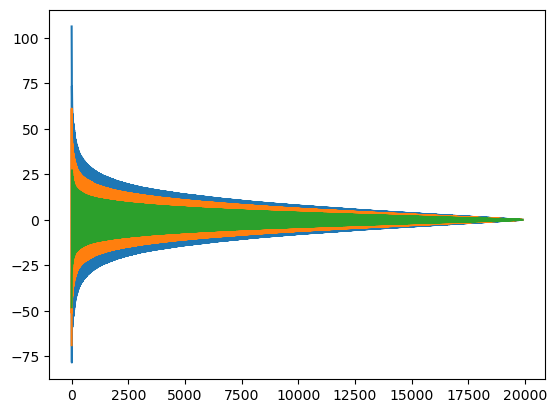

In [25]:
ranks = np.argsort(np.abs(mean_patterns), axis=0)[::-1]
sorted_patterns = np.take_along_axis(mean_patterns, ranks, axis=0)
plt.plot(
    sorted_patterns
)
plt.show()

In [26]:
# TODO Try single step max T? More permutations? Min vs max? It's a weird way to control
# for significativity since in one direction, perhaps the effect is less pronounced
# That's also the point of permutations isn't it?
m = patterns.shape[1]
u = np.zeros((m, N))
cat = 1

for b, pm in enumerate(permweights):
    
    t_perm = np.mean(pm, axis=0)[:, cat] # Compute t stats for each hypothesis
    r_m = ranks[-1, cat]
    
    u[-1, b] = abs(t_perm[r_m]) 

    for j in range(m - 2, -1, -1):
        r_j = ranks[j, cat]
        u[j, b] = max(
            u[j+1, b],
            abs(t_perm[r_j])
        )

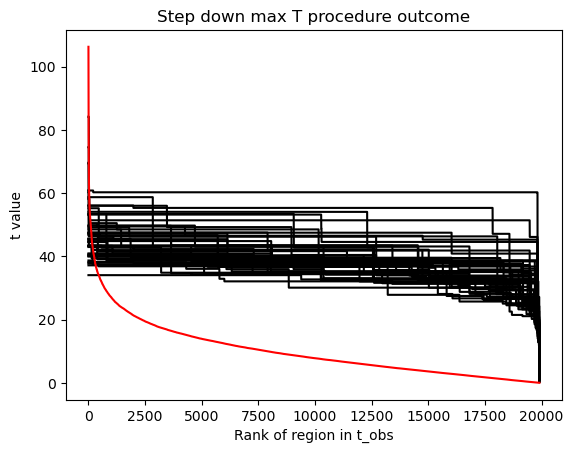

In [27]:
for b in range(0, N, 100):
    plt.plot(u[:, b], color="black")

plt.plot(np.abs(sorted_patterns)[:, 0], color="red")
plt.title("Step down max T procedure outcome")
plt.ylabel("t value")
plt.xlabel("Rank of region in t_obs")
plt.show()

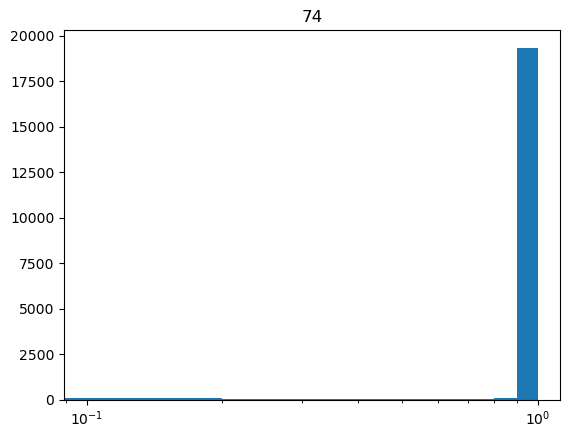

In [28]:
msk = np.abs(mean_patterns[:, 0].reshape((-1, 1))) <= u
pwest = np.sum(msk, axis=1) / N
plt.hist(pwest)
plt.xscale("log")
plt.title(np.sum(pwest < 0.05))
plt.show()

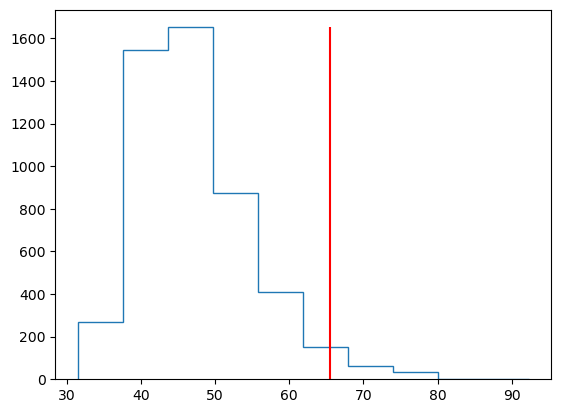

In [29]:
idx = np.where(pwest < 0.05)[0][1]
h = plt.hist(u[idx, :].flatten(), histtype="step")
plt.vlines(mean_patterns[idx, 0], ymin=0, ymax=np.max(h[0]), color="red")
plt.show()

## Perms + FDR control

In [30]:
from nilearn.connectome import vec_to_sym_matrix
from statsmodels.stats.multitest import fdrcorrection
n_regions = int(np.sqrt(masker.topology_.sum()))

mean_perm_patterns = np.stack(permweights, axis=0).mean(axis=1)
mean_patterns = np.mean(patterns, axis=0)

pvalues_more = np.sum(mean_patterns > mean_perm_patterns, axis=0) / N
pvalues_less = np.sum(mean_patterns < mean_perm_patterns, axis=0) / N
pvalues = np.minimum(pvalues_less, pvalues_more) * 2

pvalues_corr = []
for class_idx in range(k):
    pvalues_corr.append(fdrcorrection(
        pvalues[:, class_idx]
    )[1])
pvalues_corr = np.stack(pvalues_corr, axis=1)
pvalues_corr = vec_to_sym_matrix(
        pvalues.transpose((1, 0)), diagonal=np.zeros((k, n_regions))
)

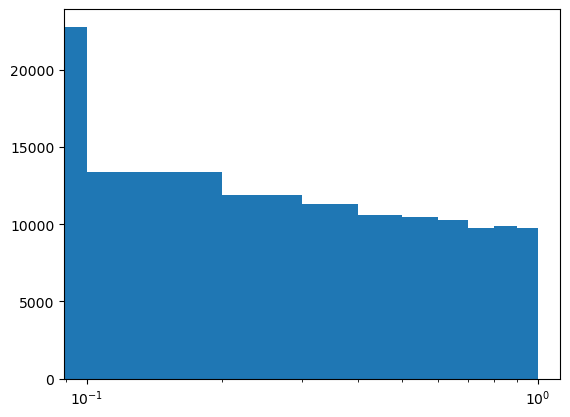

In [31]:
plt.hist(pvalues_corr.flatten())
plt.xscale("log")
plt.show()

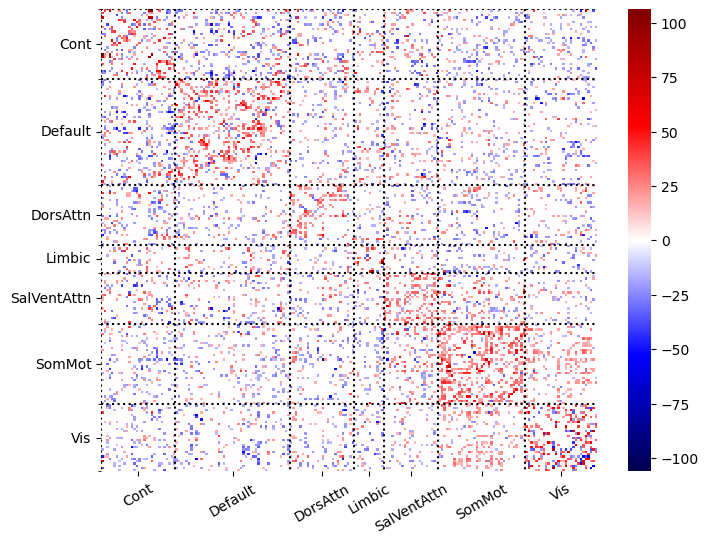

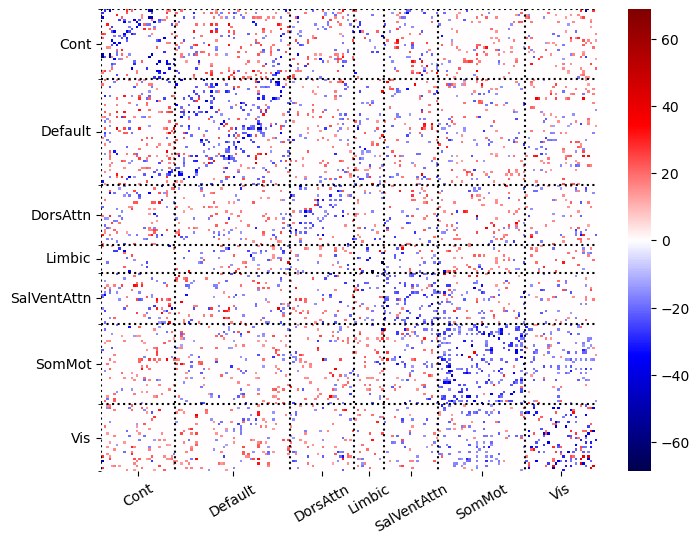

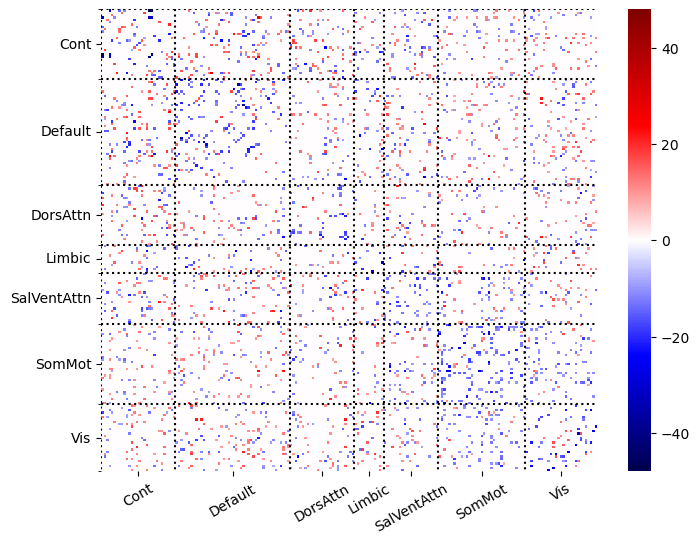

In [64]:
realised_mm = hmat.mean(axis=0)
thresh_map = np.where(pvalues_corr < (0.05), realised_mm, 0)
plot_matrix(thresh_map[0], disp_atlas, cmap="seismic")
plt.show()
plot_matrix(thresh_map[1], disp_atlas, cmap="seismic")
plt.show()
plot_matrix(thresh_map[2], disp_atlas, cmap="seismic")
plt.show()

In [59]:
# TODO Matrix group groupby, custom func
# Matrix and atlas as attributes
from neuroginius.networks import group_by_networks
from neuroginius.atlas import Atlas
from neuroginius.iterables import unique, all_equal, join, all_connectivities
import itertools as it

def default_agg_func(block):
    return (block.mean(),)

class MatrixResult:
    def __init__(self, matrix, atlas) -> None:
        self.atlas = atlas
        self.matrix = matrix
        self._set_sorted_matrix()
    
    def _set_sorted_matrix(self):
        """Reorganize the matrix by macro labels, store
        the sorted matrix and a mapping from networks name
        to indexes in the sorted matrix
        """

        ticks, sort_index = group_by_networks(self.atlas.macro_labels)
        matrix_sort = np.ix_(sort_index, sort_index)

        self.sorted_matrix = self.matrix[matrix_sort]
        new_labels = sorted(tuple(unique(atlas.macro_labels)))
        self.network_to_idx = pd.Series(dict(zip(
            new_labels,
            it.pairwise(ticks)
        )))

    def get_macro_matrix(self, agg_func=default_agg_func):
        """Get a matrix reorganized by networks

        Args:
            agg_func (function, optional): function to compute
            the aggregated of each cell, from the block of original
            values. Defaults to default_agg_func, which performs a simple
            mean

        Returns:
            DataFrame: summary per network of the original matrix.
        """
        gen = self._gen_macro_values(
            agg_func=agg_func
        )
        comparisons = pd.DataFrame(gen, columns=["node_a", "node_b", "connectivity"])
        pivoted = comparisons.pivot(index="node_a", columns="node_b")
        return pivoted.loc[:, "connectivity"]

    # This could be a function on its own
    def _gen_macro_values(self, agg_func):
        for network_a, network_b in it.product(self.network_to_idx.index, self.network_to_idx.index):
            loc_a, loc_b = self.network_to_idx[network_a], self.network_to_idx[network_b]
            block = self.matrix[loc_a[0]:loc_a[1], loc_b[0]:loc_b[1]]

            yield network_a, network_b, *agg_func(block)
    
    def plot(self):
        pass
        
    
        

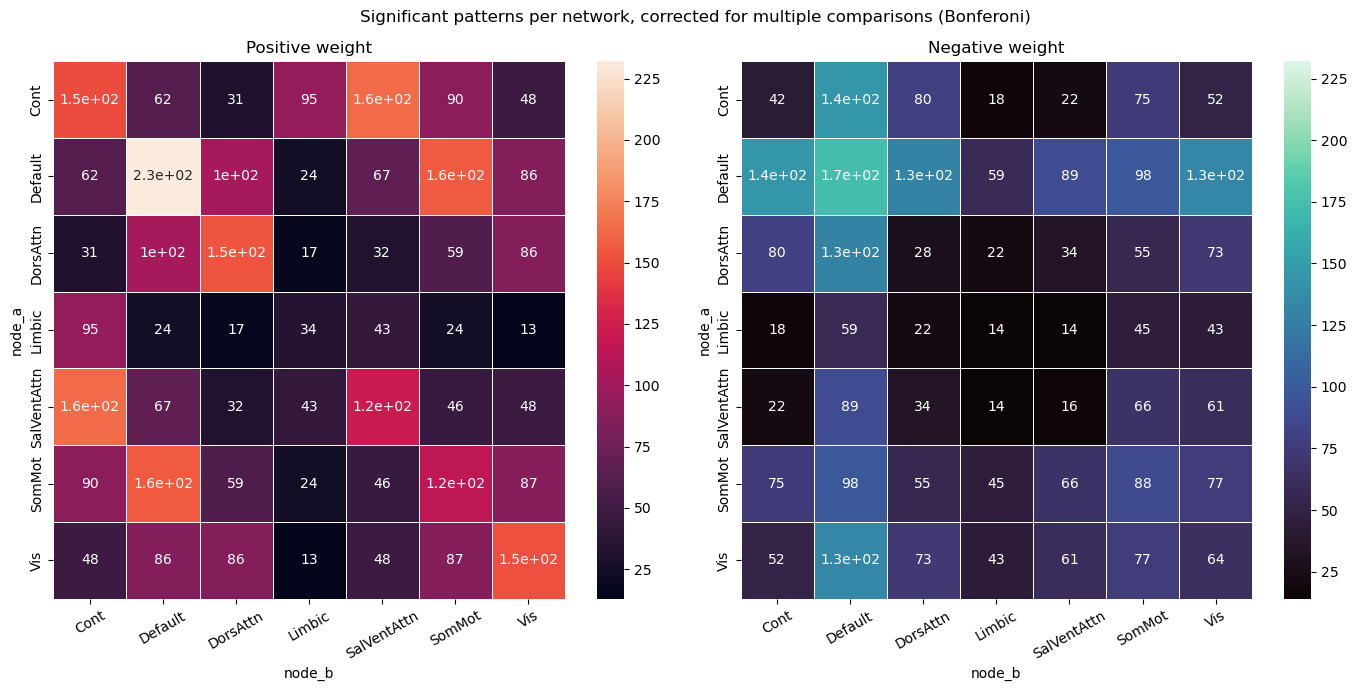

In [73]:
from neuroginius.networks import edge_counts

m = MatrixResult(thresh_map[0, :, :], atlas)
gen = m._gen_macro_values(agg_func=edge_counts)
comparisons = pd.DataFrame(gen, columns=["node_a", "node_b", "npos", "nneg", "activation"])
comparisons_pv = comparisons.pivot(index="node_a", columns="node_b")


max_count = comparisons_pv.values.max()
heat_kwargs = {
    "vmax": max_count,
    "annot": True,
    "linewidth": 0.5
}

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
sns.heatmap(comparisons_pv.loc[:, "npos"], **heat_kwargs, cmap="rocket", ax=axes[0])
axes[0].set_title("Positive weight")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30)

sns.heatmap(comparisons_pv.loc[:, "nneg"], **heat_kwargs, cmap="mako", ax=axes[1])
axes[1].set_title("Negative weight")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30)
fig.suptitle("Significant patterns per network, corrected for multiple comparisons (Bonferoni)")
fig.tight_layout()
fig.show()


In [105]:
def make_links(matrix_df: pd.DataFrame, zoom: int=10) -> tuple:
    links = []

    for source, row in matrix_df.iterrows():
        print("source", source)
        for target_rsn, val in row.items():
            print(target_rsn)
            print(val)
            if math.isclose(val, 0) or math.isnan(val):
                continue
            elif val > 0:
                colour = "red"
            elif val < 0:
                colour = "blue"

            offset = abs((zoom * val))
            assert offset < 10, f"{source} -> {target_rsn}, Offset = {offset}"
            print(source, target_rsn, val, offset)
            if source != target_rsn:
                links.append(
                    (
                        (source, 5 - offset / 2, 5 + offset / 2),
                        (target_rsn, 5 - offset / 2, 5 + offset / 2),
                        colour
                    )
                )
            else:
                links.append(
                    (
                        (source, 0, offset),
                        (target_rsn, 10 - offset, 10),
                        colour
                    )
                )
    return links

temp = comparisons.set_index(comparisons.node_a).drop("node_a", axis=1)
make_links(temp)

source Cont
node_b
Cont


TypeError: must be real number, not str

In [93]:
make_links(comparisons.iloc[:, :4])

TypeError: must be real number, not str

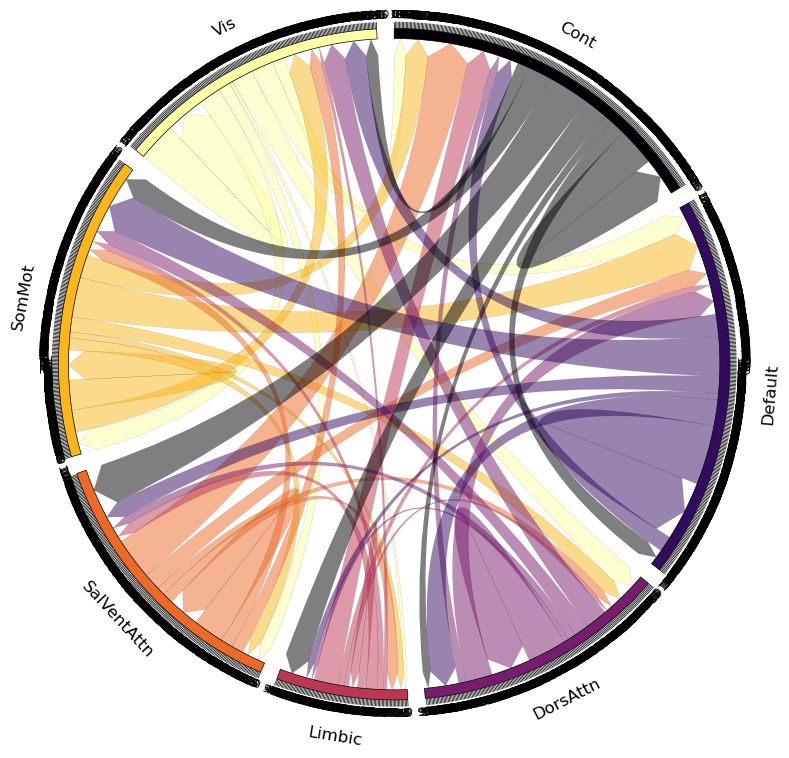

In [91]:
from pycirclize.parser import Matrix
from pycirclize import Circos
mat = Matrix.parse_fromto_table(comparisons.iloc[:, :3])
circos = Circos.initialize_from_matrix(
    mat,
    space=3,
    cmap="inferno",
    ticks_interval=5,
    label_kws=dict(size=12, r=110),
    link_kws=dict(direction=1, ec="black", lw=0.1),
)

fig = circos.plotfig()

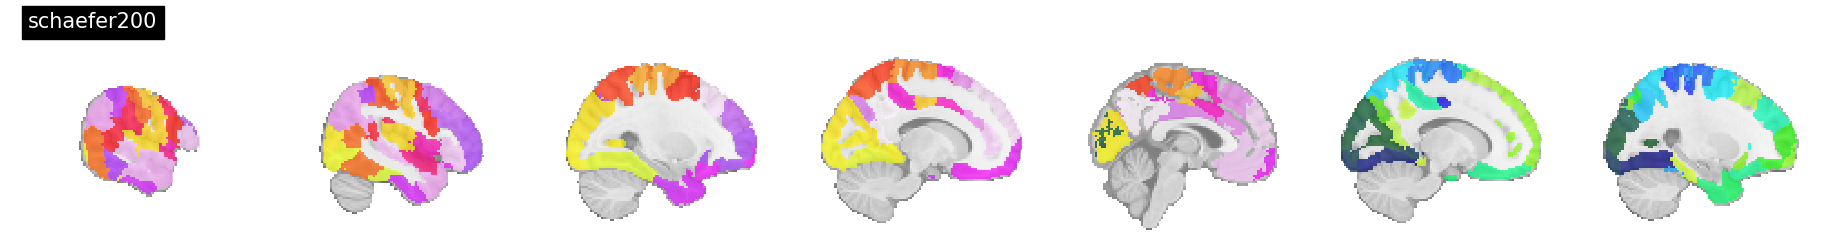

In [28]:
atlas.plot(annotate=False, display_mode="x")

In [21]:
joblib.dump(clf, run_path / "estimator.joblib") # For longitudinal study

['/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-fc_atlas-schaefer200_net-all/estimator.joblib']